In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['user_table.csv', 'test_table.csv']


In [41]:
from scipy import stats
from statsmodels.stats.weightstats import ttest_ind as sm_ttest
from statsmodels.stats.weightstats import zconfint as sm_confint

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pylab import rcParams
from pydotplus import graph_from_dot_data
from IPython.display import Image

%matplotlib inline
rcParams['figure.figsize'] = 8, 6
sns.set_style('darkgrid')

In [3]:
np.set_printoptions(precision=2)
pd.set_option('precision',2)

In [4]:
test_df = pd.read_csv('../input/test_table.csv')
user_df = pd.read_csv('../input/user_table.csv')

In [5]:
test_df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [6]:
test_cat_columns = ['source', 'device', 'browser_language','ads_channel','browser','conversion','test']

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [8]:
test_df['ads_channel'] = test_df['ads_channel'].fillna('NA')
test_df.loc[:,test_cat_columns] = test_df.loc[:, test_cat_columns].astype('category')
test_df.loc[:,'date'] = pd.to_datetime(test_df.loc[:,'date'])
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null category
device              453321 non-null category
browser_language    453321 non-null category
ads_channel         453321 non-null category
browser             453321 non-null category
conversion          453321 non-null category
test                453321 non-null category
dtypes: category(7), datetime64[ns](1), int64(1)
memory usage: 9.9 MB


In [9]:
user_df.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [10]:
user_cat_columns = ['sex', 'country']

In [11]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null object
age        452867 non-null int64
country    452867 non-null object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [12]:
user_df.loc[:,user_cat_columns] = user_df.loc[:,user_cat_columns].astype('category')
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
user_id    452867 non-null int64
sex        452867 non-null category
age        452867 non-null int64
country    452867 non-null category
dtypes: category(2), int64(2)
memory usage: 7.8 MB


In [13]:
data = test_df.join(user_df.set_index('user_id'), on='user_id', how='left')

In [14]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NA,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null category
device              453321 non-null category
browser_language    453321 non-null category
ads_channel         453321 non-null category
browser             453321 non-null category
conversion          453321 non-null category
test                453321 non-null category
sex                 452867 non-null category
age                 452867 non-null float64
country             452867 non-null category
dtypes: category(9), datetime64[ns](1), float64(1), int64(1)
memory usage: 14.3 MB


In [16]:
data[data.sex.isnull()].head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
819,657841,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0,NaN,NaN,NaN
1696,859340,2015-12-04,Direct,Mobile,EN,NA,Android_App,0,0,NaN,NaN,NaN
1934,716487,2015-12-04,SEO,Mobile,ES,NA,Android_App,0,0,NaN,NaN,NaN
2409,87209,2015-12-01,Direct,Web,ES,NA,Chrome,0,0,NaN,NaN,NaN
2721,771642,2015-11-30,SEO,Mobile,ES,NA,Android_App,0,0,NaN,NaN,NaN


In [17]:
data_cat_columns = test_cat_columns + user_cat_columns

In [18]:
print(data.describe())
print()
for col in data_cat_columns:
    print(data[col].value_counts())
    print()

          user_id        age
count   453321.00  452867.00
mean    499937.51      27.13
std     288665.19       6.78
min          1.00      18.00
25%     249816.00      22.00
50%     500019.00      26.00
75%     749522.00      31.00
max    1000000.00      70.00
()
Ads       181877
SEO       180610
Direct     90834
Name: source, dtype: int64
()
Web       251565
Mobile    201756
Name: device, dtype: int64
()
ES       377547
EN        63137
Other     12637
Name: browser_language, dtype: int64
()
NA          271444
Facebook     68425
Google       68180
Yahoo        27435
Bing         13689
Other         4148
Name: ads_channel, dtype: int64
()
Android_App    155135
Chrome         101929
IE              61715
Iphone_App      46621
Safari          41065
FireFox         40766
Opera            6090
Name: browser, dtype: int64
()
0    430846
1     22475
Name: conversion, dtype: int64
()
0    237338
1    215983
Name: test, dtype: int64
()
M    264485
F    188382
Name: sex, dtype: int64
()
Mexico  

In [19]:
data.conversion = data.conversion.astype('int')
data_conversion_country = data.loc[data.test==0, ['country', 'conversion']].groupby('country').mean().sort_values('conversion', ascending=False)
data_conversion_country.head()

,conversion
country,
Spain,0.08
El Salvador,0.05
Nicaragua,0.05
Costa Rica,0.05
Colombia,0.05


In [20]:
data_test = data[data.country != 'Spain']
data_test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NA,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NA,Android_App,0,0,M,35.0,Mexico


In [21]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401539 entries, 1 to 453320
Data columns (total 12 columns):
user_id             401539 non-null int64
date                401539 non-null datetime64[ns]
source              401539 non-null category
device              401539 non-null category
browser_language    401539 non-null category
ads_channel         401539 non-null category
browser             401539 non-null category
conversion          401539 non-null int64
test                401539 non-null category
sex                 401085 non-null category
age                 401085 non-null float64
country             401085 non-null category
dtypes: category(8), datetime64[ns](1), float64(1), int64(2)
memory usage: 18.4 MB


In [22]:
data_test.conversion = data_test.conversion.astype('float')

/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [23]:
print(stats.ttest_ind(data_test[data_test.test==1].conversion, data_test[data_test.test==0].conversion, equal_var=False))

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)


In [24]:
tstat , pvalue, df  = sm_ttest(data_test[data_test.test==1].conversion, data_test[data_test.test==0].conversion)
print(tstat , pvalue, df)
print(sm_confint(data_test[data_test.test==1].conversion, data_test[data_test.test==0].conversion))
print(data_test[data_test.test==1].conversion.mean(), data_test[data_test.test==0].conversion.mean())

(-7.422512095955904, 1.1514468785121186e-13, 401537.0)
(-0.006201094512279612, -0.003610323844808638)
(0.043424713982118966, 0.04833042316066309)


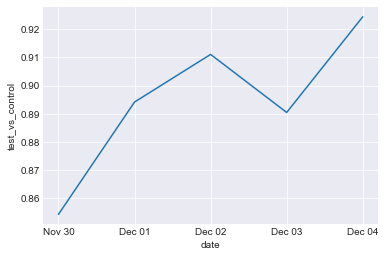

In [25]:
data_test_by_day = pd.DataFrame(data_test[data_test.test==1].groupby('date').mean()['conversion']/data_test[data_test.test==0].groupby('date').mean()['conversion'])
data_test_by_day.columns = ['test_vs_control']

plt.plot(data_test_by_day.index, data_test_by_day.test_vs_control);
plt.gca().xaxis.set_major_locator(mdates.DayLocator());
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));
plt.xlabel('date');
plt.ylabel('test_vs_control');

### Trying different encoding methods, the first two all wrong, go to get_dummies option.

In [190]:
X = data_test.drop(labels=['conversion', 'test'],axis=1)
y = data_test['test'].astype('int')

In [191]:
X.head()

,user_id,date,source,device,browser_language,ads_channel,browser,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NA,Android_App,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NA,Android_App,M,35.0,Mexico


In [192]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401539 entries, 1 to 453320
Data columns (total 10 columns):
user_id             401539 non-null int64
date                401539 non-null datetime64[ns]
source              401539 non-null category
device              401539 non-null category
browser_language    401539 non-null category
ads_channel         401539 non-null category
browser             401539 non-null category
sex                 401085 non-null category
age                 401085 non-null float64
country             401085 non-null category
dtypes: category(7), datetime64[ns](1), float64(1), int64(1)
memory usage: 24.9 MB


In [193]:
le = LabelEncoder()
ohe = OneHotEncoder()

le.fit(X['date'])
X['date'] = le.transform(X['date'])
X['date'] = X['date'].astype('category')

le.fit(X['source'])
X['source'] = le.transform(X['source'])
X['source'] = X['source'].astype('category')

le.fit(X['device'])
X['device'] = le.transform(X['device'])
X['device'] = X['device'].astype('category')

le.fit(X['browser_language'])
X['browser_language'] = le.transform(X['browser_language'])
X['browser_language'] = X['browser_language'].astype('category')

le.fit(X['ads_channel'])
X['ads_channel'] = le.transform(X['ads_channel'])
X['ads_channel'] = X['ads_channel'].astype('category')

le.fit(X['browser'])
X['browser'] = le.transform(X['browser'])
X['browser'] = X['browser'].astype('category')

le.fit(X['sex'].astype('str'))
X['sex'] = le.transform(X['sex'].astype('str'))
X['sex'] = X['sex'].astype('category')

le.fit(X['country'].astype('str'))
X['country'] = le.transform(X['country'].astype('str'))
X['country'] = X['country'].astype('category')

X['age'] = X['age'].fillna(X['age'].mean())

In [194]:
X.head()

,user_id,date,source,device,browser_language,ads_channel,browser,sex,age,country
1,497851,4,0,1,1,2,3,1,21.0,9
3,290051,3,0,0,2,1,0,0,22.0,9
4,548435,0,0,1,1,2,2,1,19.0,9
5,540675,3,1,0,1,3,0,0,22.0,15
6,863394,4,2,0,2,3,0,1,35.0,9


In [240]:
X = data_test.drop(labels=['conversion', 'test'],axis=1)
y = data_test['test'].astype('int')

In [241]:
X.head()

,user_id,date,source,device,browser_language,ads_channel,browser,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NA,Android_App,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NA,Android_App,M,35.0,Mexico


In [242]:
cat_columns = ['date','source', 'device', 'browser_language','ads_channel', 'browser', 'sex', 'country']

In [243]:
le = LabelEncoder()
X[cat_columns] = X[cat_columns].apply(le.fit_transform)
X.head()

,user_id,date,source,device,browser_language,ads_channel,browser,sex,age,country
1,497851,4,0,1,1,2,3,455,21.0,463
3,290051,3,0,0,2,1,0,454,22.0,463
4,548435,0,0,1,1,2,2,455,19.0,463
5,540675,3,1,0,1,3,0,454,22.0,469
6,863394,4,2,0,2,3,0,455,35.0,463


In [244]:
X['age'] = X['age'].fillna(X['age'].mean())

ohe = OneHotEncoder(sparse = False, categorical_features=cat_columns_indices, handle_unknown='ignore')
ohe.fit(X)
ohe.transform(X)

array([[  0.,   0.,   1., ..., 455.,  21., 463.],
       [  0.,   1.,   0., ..., 454.,  22., 463.],
       [  0.,   0.,   1., ..., 455.,  19., 463.],
       ...,
       [  0.,   0.,   0., ..., 454.,  20., 457.],
       [  0.,   0.,   0., ..., 455.,  21., 457.],
       [  0.,   1.,   0., ..., 455.,  27., 463.]])

In [31]:
X = data_test.drop(labels=['conversion', 'test'],axis=1)
y = data_test['test'].astype('int')

In [32]:
X.head()

,user_id,date,source,device,browser_language,ads_channel,browser,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NA,Android_App,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NA,Android_App,M,35.0,Mexico


In [33]:
le = LabelEncoder()
le.fit(X['date'])
# X['date'] = le.transform(X['date'])
X['date'] = X['date'].astype('category')

X['age'] = X['age'].fillna(X['age'].mean())

X = pd.get_dummies(X)

X.head()

,user_id,age,date_2015-11-30 00:00:00,date_2015-12-01 00:00:00,date_2015-12-02 00:00:00,date_2015-12-03 00:00:00,date_2015-12-04 00:00:00,source_Ads,source_Direct,source_SEO,...,country_Guatemala,country_Honduras,country_Mexico,country_Nicaragua,country_Panama,country_Paraguay,country_Peru,country_Spain,country_Uruguay,country_Venezuela
1,497851,21.0,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,290051,22.0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,548435,19.0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
5,540675,22.0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6,863394,35.0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [43]:
clf = DecisionTreeClassifier(max_depth=2,
                             min_samples_leaf = len(data_test)//100
                            )
clf = DecisionTreeRegressor(max_depth=2,
                            min_samples_leaf = len(data_test)//100
                            )
clf.fit(X,y)
print(clf.score(X, y))

0.04293528190577255


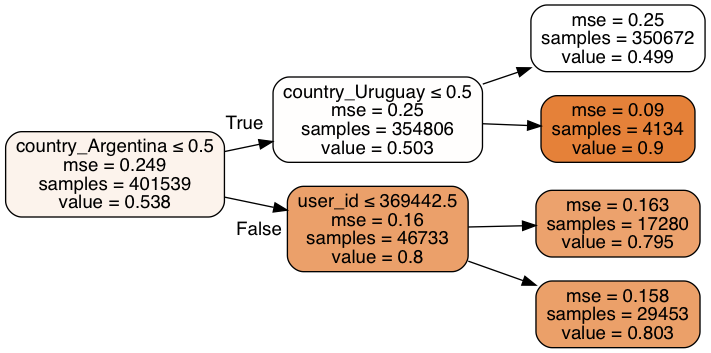

In [44]:
outfile = 'DecisionTreeClassifier.dot'
export_graphviz(clf, feature_names=X.columns, 
                class_names=['0', '1'], filled=True, 
                out_file=outfile,
                special_characters=True)
os.system('dot -Tpdf DecisionTreeClassifier.dot -o DecisionTreeClassifier.pdf');

tree = export_graphviz(clf, feature_names=X.columns, 
                       class_names=['0', '1'], filled=True, rounded=True,
                       out_file=None, special_characters=True, rotate=True)

graph = graph_from_dot_data(tree)
Image(graph.create_png())

In [45]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)

In [46]:
print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()


The binary tree structure has 7 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 30] <= 0.5 else to node 4.
node=1 test node: go to node 2 if X[:, 45] <= 0.5 else to node 3.
node=2 test node: go to node -1 if X[:, -2] <= -2.0 else to node -1.
node=3 test node: go to node -1 if X[:, -2] <= -2.0 else to node -1.
node=4 test node: go to node 5 if X[:, 0] <= 369442.5 else to node 6.
node=5 test node: go to node -1 if X[:, -2] <= -2.0 else to node -1.
node=6 test node: go to node -1 if X[:, -2] <= -2.0 else to node -1.
()


In [47]:
countries = data_test.country.cat.categories

In [48]:
np.set_printoptions(precision=7)
print ('country', 'p-value', 'conversion_test', 'conversion_control')
for country in countries.drop('Spain'):
#     print(country)
#     print(data_test[(data_test.test==1) & (data_test.country == country)].head())
    tstat , pvalue, df  = sm_ttest(data_test[(data_test.test==1) & (data_test.country == country)].conversion, 
                                   data_test[(data_test.test==0) & (data_test.country == country)].conversion)
    print(country, 
          np.array((
              pvalue,
              data_test[(data_test.test==1) & (data_test.country == country)].conversion.mean(),
              data_test[(data_test.test==0) & (data_test.country == country)].conversion.mean()
          ))
         )

('country', 'p-value', 'conversion_test', 'conversion_control')
('Argentina', array([0.3217663, 0.013725 , 0.0150705]))
('Bolivia', array([0.7188769, 0.047901 , 0.0493694]))
('Chile', array([0.3028707, 0.051295 , 0.0481072]))
('Colombia', array([0.423733 , 0.050571 , 0.0520895]))
('Costa Rica', array([0.6878629, 0.0547376, 0.0522556]))
('Ecuador', array([0.9615124, 0.0489884, 0.0491538]))
('El Salvador', array([0.2482507, 0.0479469, 0.053554 ]))
('Guatemala', array([0.5721648, 0.0486472, 0.0506429]))
('Honduras', array([0.4717212, 0.0475398, 0.0509058]))
('Mexico', array([0.1655472, 0.0511863, 0.0494946]))
('Nicaragua', array([0.7803509, 0.0541768, 0.052647 ]))
('Panama', array([0.7053612, 0.0493703, 0.0467955]))
('Paraguay', array([0.8837018, 0.0492291, 0.0484932]))
('Peru', array([0.7719499, 0.0506043, 0.049914 ]))
('Uruguay', array([0.8828124, 0.0129067, 0.0120482]))
('Venezuela', array([0.5737395, 0.0489783, 0.0503437]))


In [40]:
tstat , pvalue, df  = sm_ttest(data_test[data_test.test==1].conversion, data_test[data_test.test==0].conversion)
print(tstat , pvalue, df)
print(sm_confint(data_test[data_test.test==1].conversion, data_test[data_test.test==0].conversion))
print(data_test[data_test.test==1].conversion.mean(), data_test[data_test.test==0].conversion.mean())

(-7.422512095955904, 1.1514468785121186e-13, 401537.0)
(-0.006201094512279612, -0.003610323844808638)
(0.043424713982118966, 0.04833042316066309)
